# How to Create a Computer Vision Model to Save the Ugly Duckling from a Youth of Misery in Less Than 30 Lines of  Code

No New Year without its New Year resolution. So how about diving into computer vision, learning a new library that allows you to train a computer vision model in less than 30 lines of code and revisiting some good old fairy tales? And all at once?

Hans Christian Andersen's [tale of the ugly duckling](https://americanliterature.com/author/hans-christian-andersen/short-story/the-ugly-duckling) tells us about a cygnet (i.e. a baby swan) brought up as part of a family of ducks and being bullied by its siblings and everybody else for being ugly (read _different to them_). If only the poor cygnet had had somebody to tell it that it in fact was a swan instead! Entering Our Hero, Machine Learning to the rescue!

In this project, we will learn how to use fastai, Gradio and HuggingFace to build a magic mirror that can distinguish a duckling from a cygnet in four main steps. Then we will deploy it to the internet for all ducklings out there to use. We will learn how to:

1. Create a dataset from scratch, using a duckduckgo image search.
2. Train a train a computer vision model using [fastai](https://www.fast.ai/).
3. Build a magic mirror app using [Gradio](https://www.gradio.app/).
4. Deploy the magic mirror for free on [HuggingFace](https://huggingface.co/).

So let's get started to help the duckling answer the magical question...

**"Mirror, mirror on the wall, am I a duckling or a cygnet after all?"**

<img src="mirror-mirror.png" alt="**Mirror, mirror on the wall, am I a duckling or a cygnet after all?**" width="15%" align="middle"/>

## Preparations

### Installing Libraries

The training part of this notebook requires two non-standard libraries:

* We use `duckduckgo_search` to search for cygnet and duckling images to create the dataset.
* We use `fastai` for training the computer vision model. [fastai](https://docs.fast.ai/). Fastai is a higher-level interface to PyTorch that allows users to train to train deep learning models in very few lines of code ([here is an example of four lines of code from zero to image-classifier](https://www.fast.ai/posts/2021-08-02-fastdownload.html)).

If you run your code on Google Colab (because yeah, free GPUs!), you don't need need to worry about installing fastai, just run `! pip install duckduck-go` to install the duckduck-go library. Anywhere else, you might have to install `fastai`, too. At the time of writing, the [fastai homepage](https://docs.fast.ai/) recommends `mamba` for installation, but it's worth checking again.

In [1]:
! pip install -U duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 9.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


### Importing Modules

Library imports should happen at the top of your code, so as always let's start with importing the required libraries.

In [2]:
from pathlib import Path
from time import sleep
from dataclasses import dataclass
from typing import List

from duckduckgo_search import ddg_images

from fastai.data.transforms import get_image_files, parent_label, RandomSplitter

from fastai.interpret import ClassificationInterpretation

from fastai.metrics import error_rate

from fastai.vision.augment import Resize, RandomResizedCrop, aug_transforms
from fastai.vision.core import DataBlock
from fastai.vision.data import CategoryBlock, ImageBlock
from fastai.vision.all import vision_learner  # import from vision.all due to patching
from fastai.vision.utils import download_images, get_image_files, verify_images

from fastcore.foundation import L

from torchvision.models.resnet import resnet18

Note that due to the [large number of required imports](https://forums.fast.ai/t/cnn-learner-returning-a-sequential-object-with-missing-methods/90378) and the [extensive monkey patching in the library](https://forums.fast.ai/t/cnn-learner-returning-a-sequential-object-with-missing-methods/90378) the recommended way of importing fastai libraries is to use 
`from fastai import *` or `from fastai.vision.all import *` (take a look at [walk-with-fastai's first lesson](https://walkwithfastai.com/Pets) to get an impression of the extend of both).
However, since wildcard imports are typically discouraged (with exceptions for ad-hoc work), I tend to import the libraries one by one and resolve [issues as they appear](https://stackoverflow.com/questions/65128126/fast-ai-attributeerror-learner-object-has-no-attribute-fine-tune). This also forces me to become more familiar with the internal organization of the library itself, something I appreciate. When running into issues I find the following steps helpful.

### How to troubleshoot imports

1. Run `from fastai import *` to see if this solves your issue.
2. If so, use `which functionname` to find out from where you should be actually importing your library
3. Adapt your import statement accordingly.

An example of one of these patching issues is that `vision_learner` should be imported from `fastai.vision.all` instead of from `fastai.vision.learner`.
If you in general don't want to go into too many details with your imports, you can also strike a happy medium by importing modules from `fastai.vision.all`.  

## Creating the Dataset

No machine learning without data. To create our dataset, we implement the following steps:

* Use duckduckgo's image search to get a list of urls of images of ducklings and cygnets.
* Download the images to our system using fastai's `download_images()`.
* Check if the downloaded images are ok using fastai's `verify_images()`.
* Delete images which are not ok.

Once we have built the dataset, we will use it to train a classifier. A common image classification folder structure is to save the images in folders named according to their label. To decouple the label from the actual searchterm and create more flexibility in setting up our search, we create a `Searchterm` dataclass that holds both the search term and the label.

In [ ]:
IMAGEPATH = Path().cwd()/'images'

@dataclass
class Searchterm:
  searchstring: str
  label: str


def search_images(searchterm: str, max_results: int) -> L:
    """Uses duckduckgo to search for images"""

    return L(ddg_images(searchstring,
                        max_results=max_results)).itemgot('image')


def delete_invalid_images(imagepath: Path) -> int:
    """Deletes invalid images in imagepath"""

    invalid_images = verify_images(get_image_files(imagepath))
    invalid_images.map(Path.unlink)
    return len(invalid_images)


def download_search_data(terms: List[Searchterm], n_searches) -> None:
    """Searches for images and downloads results"""
    for term in terms:
        print(f"Downloading {n_searches} images for {term.searchstring} into folder {term.label}.")
        folder = IMAGEPATH/term.label
        folder.mkdir(parents=True, exist_ok=False)

        download_images(folder,
                        urls=search_images(f"{term.searchstring}",
                                        max_results=n_searches))

        print(f"Deleted {delete_invalid_images(IMAGEPATH/term.label)} invalid images for {term.searchstring}")

### On Finding the Right Search Terms

To make sure that one downloads a useful dataset, it helps to start the process by manually running a few searches and having a look at the general results of the query. Doing this process manually allows you to quickly tweak your query string till it returns useful images and helps to avoid the [garbage in - garbage out problem](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out).

For this project, I found that searching for "cygnet" not only returned images of actual cygnets, but also returned images wool and alcohol bottles (both of brands with "cygnet" in the name). There are technical ways of dealing with this problem, but the most straight forward solution is to simply change the search string to "baby swan", which solved the issue perfectly. In a similar project, I wanted to get photos in different lighting conditions, but realized that whilst looking for "objectname sun" returned useful results, looking for "objectname shade" did mostly return undesired results, so was not recommendable.

![Not the type of cygnet we were looking for](wrong-type-of-cygnets.png)

Once we have found good search strings, we can run our search and download some images!
The following code downloads 100 images for "baby swan" and "duckling" each, checks them and deletes broken images. In my experience, about 2-3 images are typically broken, so afterwards we are left with a little under 100 actual images.

In [ ]:
# Clean folder structure
IMAGEPATH.delete()

download_search_data([Searchterm(searchstring='baby swan', label='cygnet'),
                      Searchterm(searchstring='duckling', label='duckling')],
                     n_searches=100)

Deleted 3 invalid images for baby swan
Deleted 2 invalid images for duckling


Nice! 

## Training the Image Classifier

### Setting up the DataLoader

Next, we need to tell fastai how to convert the images in their folders into image batches that it can train the classifier on. fastai loads data using a `Dataloaders` object, so we need to tell it how to create one. One way to create a `DataLoaders` object is to first create a `DataBlock`, then call the `dataloaders()` method on it.

This is how this looks like for our case:

In [ ]:
birds = DataBlock(blocks=(ImageBlock, CategoryBlock),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=RandomSplitter(valid_pct=0.2, seed=42),
                  item_tfms=[RandomResizedCrop(256, min_scale=0.8)],
                  batch_tfms=aug_transforms())

dls = birds.dataloaders(IMAGEPATH, bs=64)

So what does this mean?

The five things we need to tell fastai when creating a `DataLoaders` object are:

* What type of data are input and output data?
* How should it load the data?
* For a classification task: How can it determine the labels?
* How should it create a validation set?
* Which data transformations should it apply? Are these individual or batch transformations?

#### Data Transformations: Image Resizing and Augmentation

Data transformations come in two flavours, individual and batch transformations. Individual transformations are applied to each image individually, batch transformations are applied to a whole batch in parallel at the same time (making them a lot faster).

Typical data transformations for image data are resizing and image augmenation tasks. In order to train a neural network on image data, the images need to be of the same size. We can achieve this through:

* cropping
* squishing
* padding
  
All of these have their drawbacks. Cropping might delete important parts of the image, squishing distorts the image and padding introduces useless data points thereby unnecessarily increasing computational costs.

In order to prevent overfitting (especially when dealing with small datasets), we might also apply augmentations to our image dataset. Augmentations can happen on an image or on a pixel level. Examples of augmentations on an image level are:

* flipping
* rotation
* perspective warping

Examples of pixel augmentations are changes to:

* brightness
* saturation
* hue
* contrast
  
Different augmentations are applied in each batch.

With that knowledge, lLet's look at the inputs to `DataBlock` in more detail.

* `blocks=(ImageBlock, CategoryBlock)`

   Trains an image classifier: images as input, categories as output.
* `get_items=get_image_files`

   Loads the images by applying the `get_image_files` function to the path specified as input to the `dataloaders` function.
* `get_y=parent_label`

   Gets the image labels by using the `parent_label` function, which extracts the label from the folder name.
* `splitter=RandomSplitter(valid_pct=0.2, seed=42)`

  Splits the data into training and validation sets by randomly assigning 20% of the data to the validation set. Seeds the random number generator to 42. Note that `Dataloaders` forces you to adhere to best practice and create a validation set. Here, we seed the random number generator to make the split reproducible across multiple runs. As always it's completely up to you which seed you choose (even though [42 is often used](https://medium.com/geekculture/the-story-behind-random-seed-42-in-machine-learning-b838c4ac290a)).

* `item_tfms=[RandomResizedCrop(256, min_scale=0.8)]`

   Applies the item transformation `RandomResizedCrop()`. Randomly crops a part of the image (keeping at least 80% of the original image), then scales it to 256x256 pixels. A different random crop is selected for each batch.
  
* `batch_tfms=aug_transforms()`

  Applies the batch transformation `aug_transforms()`, which is a set of transformations designed by fastai to work well for natural photos.

Having created our data set batches, let's inspect a few of the resulting images (including their augmentations)

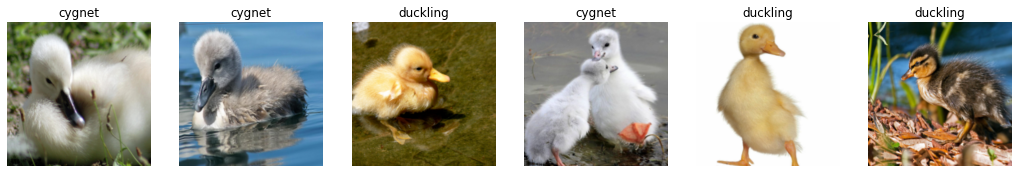

In [ ]:
# Inspect some images
dls.train.show_batch(max_n=6, nrows=1)

Looking good :) Next, we set up the learning part.

### Setting up the Learner

We use fastai's `vision_learner()` function to create a [Residual Neural Network (ResNet)](https://arxiv.org/abs/1512.03385) with 18 hidden layers. ResNets counteract the [problem of vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) by including skip-layers in their architecture. Skip-layers allow gradient information to propagate through the network more easily by adding the output of previous layers to layers deeper in the network. This allows for the training of deeper networks (the original paper demonstrated the successful training of a 152-layer network and even experimented with up to 1002 layers). The ResNet-18 architecture is the smallest ResNet architecture, making it quite fast to train. Whilst smaller networks can result in lower prediction accuracy, a ResNet-18 archicture is perfectly suitable for our toy problem.

In order to achieve good results with few training iterations and a small dataset, we take advantage of transfer learning. In transfer learning, we initialize the model weights with weights that have been trained on a large corpus of data and fine-tune only some of them to our specific problem (often we might change only the weights of the actual classification layer). By default, fastai uses weights which were pre-trained using the [ImageNet corpus](http://www.image-net.org).

To find a good number of fine-tuning steps (good accuracy without overfitting), we train the model while we observe training and validation losses. While the training loss will continue to go down with more training steps, the validation loss will first decrease, then eventually start increasing again when the model starts overfitting to the training data. This point of onsetting overfitting gives as a good number of training steps. In our case, this is about 5.

Let's train the model!

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

# 5 is a good number of steps, afterwards the validation loss starts increasing
learn.fine_tune(5)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.322290,0.665758,0.243243,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.537393,0.333642,0.135135,00:58
1,0.390109,0.203725,0.081081,00:58
2,0.283819,0.161411,0.054054,00:58
3,0.218951,0.160250,0.054054,01:00
4,0.174419,0.154186,0.054054,00:57


## Evaluating Your Model

Having trained the model, let's evaluate its performance. Whilst loss is the algorithm's metric of driving the optimization to better results, it's not a very humanly understandable metric. So let's look at the confusion matrix instead to see how well our model is performing.

### Confusion Matrix

The confusion matrix compares the predicted with the true class for each image and shows us a summary for all images in the validation set. Below, we see that all cygnets in the validation set were correctly classified as such, whilst two of the ducklings were misclassified as cygnets. Overall not too bad an outcome.

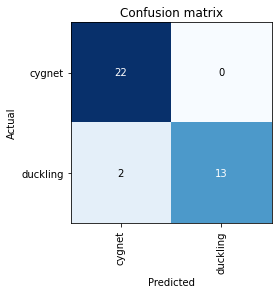

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Largest Losses

For a more detailed view, let's go back to the losses. Using `interp.plot_top_losses()`, we can display the images with the highest losses. A higher loss means that either the algorithm has correctly predicted the class of an image, but is not very certain of it or it has incorrectly predicted the class of an image (the more certain of an incorrect prediction it is, the higher is the loss).#### Largest Losses

For a more detailed view, let's go back to the losses. Using `interp.plot_top_losses()` function, we can display the images with the highest losses. A higher loss means that either the algorithm has correctly predicted the class of an image, but is not very certain of it or it has incorrectly predicted the class of an image (the more certain of an incorrect prediction the higher the loss).

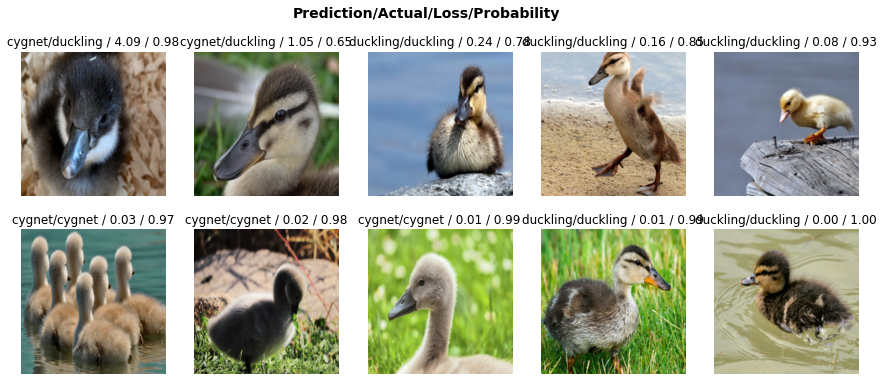

In [ ]:
interp.plot_top_losses(10, nrows=2)

The two largest contributions to the loss are the two misclassified ducklings, which we have already encountered in teh classification matrix, followed by correctly classified images, but with less certainty. We see that image with the largest loss is an image of a duckling that looks very different from most of the other ducklings in the dataset. Without being a ornithologist, my impression is that most of the ducklings in the dataset are Mallard ducklings, whilst this one might not be. Unfortunately I could not find which type of duck this might be (any ornithologist willing to help?). This is a good demonstration that it is always worth to keep track of where your data is coming from (in this case URLs, image captions, etc). It makes these type of investigations a lot easier. Going back to the original task, if we were serious about good performance, it might be beneficial to deal with these dataset outliers by for example eliminating everything which isn't a Mallard duckling from our dataset (assuming that our users are only interested in classifying Mallards that is) or adding more ducklings of other types to the data.

To find the associated files to your losses, use `interp.top_losses(items=True)` to display all losses together with the associated file paths.The two highest loss values are produced by the misclassified ducklings, in order of descending certainty, followed by correctly classified images, but with less certainty. 

An observation: It is noticable that the image with the highest loss is an image of a duckling that looks very different from most of the other ducklings in the dataset. My impression is that most of the ducklings in the dataset are Mallard ducklings, whilst this one is not. Unfortunately I could not find which type of duck this might be (any ornithologists in the audience willing to help out?). This is a good demonstration of why when building datasets from searches it is a good idea to save the URLs and potentially the names of the retrieved files. It makes these type of investigations a lot easier to conduct. Going back to the original task, if we were serious about good performance, it might be beneficial to deal with these dataset outliers by for example eliminating everything which isn't a Mallard duckling from our dataset (assuming that our users are only interested in classifying Mallards that is) or adding more ducklings of other types to the data. 

Assuming that you would like to delete all non-Mallard ducklings from the dataset, you can use the `interp.top_losses(items=True)` to display all losses together with the associated file paths and then use the filepaths to purge the images from your dataset.

In [ ]:
# items=True returns the file paths
interp.top_losses(items=True)

(TensorBase([4.0928e+00, 1.0488e+00, 2.4337e-01, 1.5965e-01, 7.6476e-02,
             3.3652e-02, 1.8994e-02, 1.2116e-02, 8.2581e-03, 4.4039e-03,
             2.3067e-03, 1.1670e-03, 1.0680e-03, 3.9296e-04, 1.9465e-04,
             1.7105e-04, 1.6032e-04, 1.5162e-04, 1.2433e-04, 1.0645e-04,
             9.7032e-05, 8.8569e-05, 6.5563e-05, 6.4609e-05, 5.8292e-05,
             5.4239e-05, 4.1842e-05, 3.9338e-05, 3.0517e-05, 2.6583e-05,
             1.7047e-05, 1.4305e-05, 3.5763e-06, 1.5497e-06, 1.0729e-06,
             4.7684e-07, 2.3842e-07]),
 TensorBase([ 2,  6, 18, 12, 32, 11,  8, 17, 31, 26,  3, 22, 14,  7, 34, 20, 24,
             33, 36,  4, 16, 29, 21, 15, 13, 10, 35,  1, 19,  9, 23, 27, 28, 30,
             25,  0,  5]),
 (#37) [Path('/content/images/duckling/2f13f591-286d-4f14-afd2-20aa4ba8d852.jpg'),Path('/content/images/duckling/6fce9794-6570-4be0-afd9-8b4db5eb77d0.jpg'),Path('/content/images/duckling/e0951cbb-726c-4f12-9259-6f24f7981504.jpg'),Path('/content/images/duckling/

### More Data Cleaning Options

Another handy tool for image data cleaning is the `ImageClassifierCleaner()` function. Apply it to a learner to get a drop-down interface allowing you to easily relabel or delete images from your dataset.

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

![ImageClassifierCleaner](data-cleaning.png)

Note that the above only provides the graphical interface, you still need to relabel and/or delete the actual images. You can do this by using the following code. You need to run it for each combination of drop-downs that you want to treat.

In [ ]:
import shutil

def execute_cleaning(cleaner):
    # Run this for every combination of category and validity, it does not save!

    # delete the ones to be deleted
    for idx in cleaner.delete():
       cleaner.fns[idx].unlink()

    # move the ones to be relabeled into their new folders
    for idx, category in cleaner.change():
       shutil.move(str(cleaner.fnx[idx], IMAGEPATH/category))

## Export Model

Finally we can export the model for later use. In the next step, we will see how to export it to HuggingFace to deploy it!

In [ ]:
learn.export('duckling_learner.pkl')

## Building a Gradio Interface on HuggingFace

Now that we have a trained model, we want to wrap it in a user interface and host it to share it with all the cygnets and ugly ducklings out there. Luckily, there are plenty of options to host ML based apps for free. Where you can do so, will also depend on how you decide to implement the interface.

Some easy, straight-forward, python based options for building graphical model interfaces are:

* Gradio
* Streamlit
* Voila

Depending on your choice of GUI, some options to serve your interface are:

* Gradio: Hugging Face
* Streamlit: Hugging Face, Streamlit Community
* Voila: GitHub, Binder

Here, I will show how to build an app using Gradio and host it on HuggingFace. This is mostly because I had used some of the other ones in the past and wanted to try out something new. Either of the options above will serve you well.

This is how my Gradio app looks like. To try it out for yourselve, find its [live version on HuggingFace](https://huggingface.co/spaces/walkenho/ugly-duckling-magic-mirror).

<img src="app-screenshot.png" alt="**Gradio App on HuggingFace?**" width="75%" align="middle"/>

In order to host a Gradio app like the one shown above on HuggingFace, you need six files:

1. the main file defining the Gradio app
2. the ML model for scoring
3. a `README.md` defining the app's metadata (eg its title)
4. a `requirements.txt` file defining extra packages that need to be installed
5. a `.gitignore` file (telling HuggingFace's git which files to ignore and which to handle using `git-lfs`)
6. (optional) the example images that the user can click on

Let's go through the files one-by-one. If you want to check out the exact files, you can find them in [my ugly-duckling HuggingFace space](https://huggingface.co/spaces/walkenho/ugly-duckling-magic-mirror/tree/main).

### File 1: Main File - Gradio App

This is the complete code for the Gradio interface:

In [ ]:
from pathlib import Path
from fastai.vision.learner import load_learner
import gradio as gr

MODELPATH='cygnet-vs-duckling.pkl'

learn = load_learner(MODELPATH)
categories = learn.dls.vocab

def classify_image(image):
    _, _, probs = learn.predict(image)
    return dict(zip(categories, map(float, probs)))

title = 'Mirror, Mirror on the Wall, am I a Duckling or a Cygnet after all?'
description = """Hans Christian Andersen's tale of the ugly duckling tells us about the sad youth of a cygnet which is accidentally brought up in a family of ducks and is ostrized on the account of it being different. But what if the cygnet had had a magic mirror to tell it that it had been a young swan all along? Machine learning to the rescue!"""

examples = ['duckling.jpg', 'cygnet.jpg']

article = '**Technical Details**: The classification model was build using a resnet-18 architecture. Training was done using a transfer learning approach. I took the publicly available weights that were pre-trained on the ImageNet data set and fine-tuned them using about 80 images of ducklings and cygnets each.\nNote that it is binary classifier and will therefore only output "cygnet" or "duckling", "other" is not an option.' 

app = gr.Interface(fn=classify_image,
                   inputs=gr.components.Image(),
                   outputs=gr.components.Label(),
                   examples=examples,
                   title=title,
                   description=description,
                   article=article,
                   allow_flagging='never')

app.launch()

Easy, right? But what does it do? Let's start by looking at the `Interface` function.

The parameters of the `Interface` function tell Gradio that it should take an image as an input and generate a label as output using the scoring function `classify_image`. Gradio expects the scoring function to output a dictionary with the labels as keys and the associated probabilities as values. Note that `predict` returns the probabilities as tensors, which means that we need to convert them to floats for gradio to be able to handle.

To show this, here is an example of how to use `predict` and its output format. Below, we load an image from disk, convert it into a pillow file and score it using the previously loaded model. Note how the returned probabilities are tensors? 

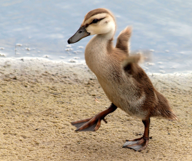

In [ ]:
from fastai.vision.all import PILImage

im_duckling = PILImage.create('/content/images/duckling/54388c76-bf64-4751-96a9-0624c0139719.JPG')
im_duckling.thumbnail((192, 192))
im_duckling

In [ ]:
learn.predict(im_duckling)

('duckling', TensorBase(1), TensorBase([0.0242, 0.9758]))

Now that we have the main interface, let's have a quick look at the additional files. 

## File 2: ML Model

We need to upload the previously saved model to HuggingFace so that we can use it for scoring. In order to be able to upload the model, you need to have [Git-LFS](https://www.atlassian.com/git/tutorials/git-lfs) installed and enabled in your repository. Git-LFS (Large File Storage) is a Git extension that allows you to download large files in your repository lazily, which makes them easier to handle and reduces your repository size.

### File 3: Metadata - Readme.md

The Readme.md contains the metadata for the app. For the app above, it looks like this.

```
title: Magic Mirror
emoji: 🪞🦢
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 3.10.1
app_file: app.py
pinned: false
```

### File 4: Dependencies - Requirements.txt

Since we have already told HuggingFace to use Gradio in the Readme, gradio get automatically installed in the workspace. So the only external library to install is fastai, leaving the requirements file with a single line, reading `fastai`.

### File 5: Handling Files in Git: .gitignore

The `.gitignore` file comes with the HuggingFace repository. You can use it as it is.

### File(s) 6 (optional): Example Images

If you have specified example images, you need to upload them. Again, Git-LFS is required.

And that's it! Upload everything to HuggingFace and tell your friends! :)

## Final Thoughts

The model produced here is a toy model to demonstrate the overall workflow with many short-comings. One of them is that it is a binary classifier, where the categories do not span the entire possible space. This means that the classifier has to decide if it thinks that the image is more likely a duckling or more likely a cygnet. Saying "Don't be silly, this image is clearly a pineapple!" is just not an option. With that being said, I will leave you to marvel (or maybe chuckle?) at the following...

![Correctly Scoring Donald Duck's Nephews](huey-dewey-louie.png "Title")

![How would it know???](swanlake.png "Swanlake Ballerina")

Or if you are feeling adventurous test it out for yourself...

Apparently I am more of a duckling than Huey, Dewey and Louie together. Not sure what my self-esteem has to say to that ... :-/

![Apparantly, I am a duckling...](jessica-duckling.png)